In [19]:
# Import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.coordinates import SkyCoord
from matplotlib.cm import ScalarMappable

# Plots for the Fink-FAT paper

### Solar System Candidates classification evolution

In [4]:
false_sso_cand = pd.read_parquet("data/false_sso_cand.parquet")
true_sso_cand = pd.read_parquet("data/true_sso_cand.parquet")

In [5]:
from collections import Counter
def test_real_false_sso(x):
    count_tags = Counter(x["collect_list(fink_class)"])
    return len(count_tags) != 1

real_false_sso = false_sso_cand[false_sso_cand.apply(test_real_false_sso, axis=1)]

In [6]:
confusing_class = real_false_sso.explode("collect_list(fink_class)").reset_index(drop=True)

confusing_class['collect_list(fink_class)'] = pd.Categorical(
    confusing_class['collect_list(fink_class)'], 
    ['SN candidate','Unknown','Ambiguous','Early SN Ia candidate', 'Solar System MPC', 'Microlensing candidate', 'Kilonova candidate']
)

confusing_class = confusing_class[confusing_class["collect_list(fink_class)"] != "Solar System candidate"]

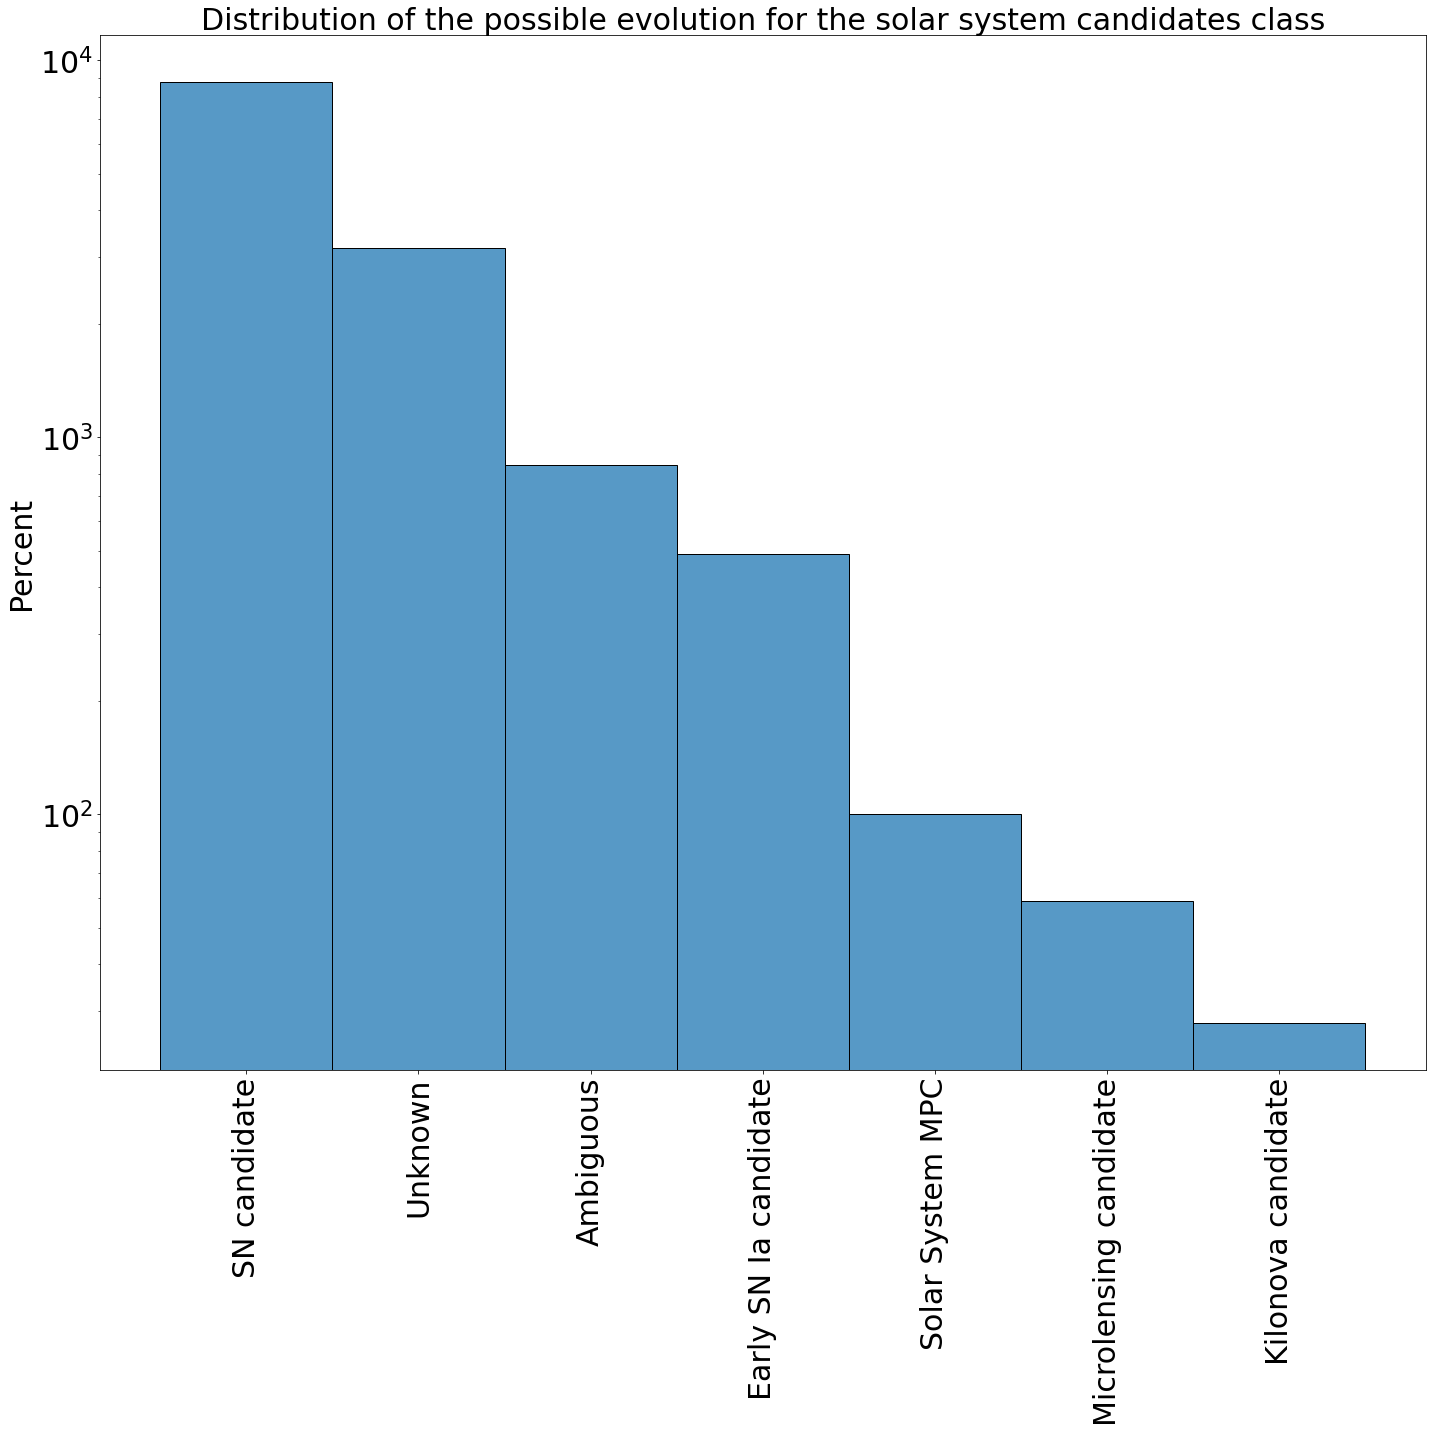

In [13]:
fig = plt.figure(figsize=(20, 20))
ax = sns.histplot(
    data=confusing_class,
    x="collect_list(fink_class)"
)
ax.set_xlabel("class", fontsize=30)
ax.set_ylabel("Percent", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
plt.xticks(rotation=90)
plt.yscale("log")
plt.xlabel("")
plt.title("Distribution of the possible evolution for the solar system candidates class", fontsize=30)
plt.tight_layout()
plt.show()

In [10]:
bad_sso_percent = (len(real_false_sso) / (len(real_false_sso) + len(true_sso_cand))) * 100

bad_sso_percent, 100 - bad_sso_percent

(0.7244054315690327, 99.27559456843096)

In [15]:
mpc_fink = pd.read_parquet("all_mpc_database.parquet")

### Galactic distribution of Solar System object in Fink

In [20]:
def eq2gal(ra, dec):

    """
    Transforms equatorial coordinates to galactic ones.
    Then prepares them for matplotlib aitoff projection. 
    """

    eq = SkyCoord(ra, dec, unit=u.deg)
    gal = eq.galactic

    # Minus appears because of “mapping from the inside” issue
    l_gal, b_gal = gal.l.wrap_at("180d").radian, gal.b.radian

    return l_gal, b_gal


def ecl2gal(lon_ecl, lat_ecl):

    """
    Transforms ecliptic coordinates to galactic ones.
    Then prepares them for matplotlib aitoff projection.
    """

    ecl = SkyCoord(lon_ecl, lat_ecl, unit=u.deg, frame="barycentricmeanecliptic")
    gal = ecl.transform_to("galactic")

    # Minus appears because of “mapping from the inside” issue
    l_gal, b_gal = gal.l.wrap_at("180d").radian, gal.b.radian

    return l_gal, b_gal

In [21]:
def fov_sso_candidates(mpc_data, title, save_dest):

    cmap = plt.get_cmap("Spectral")
    norm = plt.Normalize(mpc_data["field_percent"].min(), mpc_data["field_percent"].max())

    gal = SkyCoord(mpc_data["ra"], mpc_data["dec"], unit="deg").galactic

    fig = plt.figure(figsize=(15, 10))
    ax = plt.subplot(projection="aitoff")

    plt.scatter(
        -gal.l.wrap_at("180d").radian,
        gal.b.radian,
        c=cmap(norm(mpc_data["field_percent"].values)),
        alpha=0.1,
        marker="."
    )

    plt.legend(fontsize=16, loc="upper left")

    x = np.arange(-180, 180, 0.1)
    plt.plot(x, [20 * np.pi / 180] * len(x), color="C3", alpha=0.8)
    plt.plot(x, [-20 * np.pi / 180] * len(x), color="C3", alpha=0.8)


    # Equatorial plane
    ra_all = np.linspace(-180, 180, 100)
    dec_0 = np.zeros(100)

    l_eq_gal, b_eq_gal = eq2gal(ra_all, dec_0)

    # Ecliptic plane
    lon_ecl = np.linspace(0, 360, 100)
    lat_ecl = np.zeros(100)

    l_ecl_gal, b_ecl_gal = ecl2gal(lon_ecl, lat_ecl)

    plt.scatter(-l_eq_gal, b_eq_gal, s=4, marker="v", label="Celestial Equator")
    plt.scatter(-l_ecl_gal, b_ecl_gal, s=4, marker="^", label="Ecliptic")

    fig.suptitle(title, y=0.95)

    sm =  ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.ax.set_title("Number of SSO per ZTF field of view ")

    plt.savefig("sso_plot/{}".format(save_dest))
    plt.legend(loc="upper left", bbox_to_anchor=(-0.12, 1.2, 0., 0.))
    plt.plot()

In [ ]:
field_ready = field_percent.drop_duplicates("ssnamenr")